<a href="https://colab.research.google.com/github/Jeremy26/hydranets_course/blob/main/MTL_PyTorch_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Multi-Task Learning Workshop!
In this workshop, you're going to learn how to build multi-output networks with PyTorch.<p>
Something like this image:

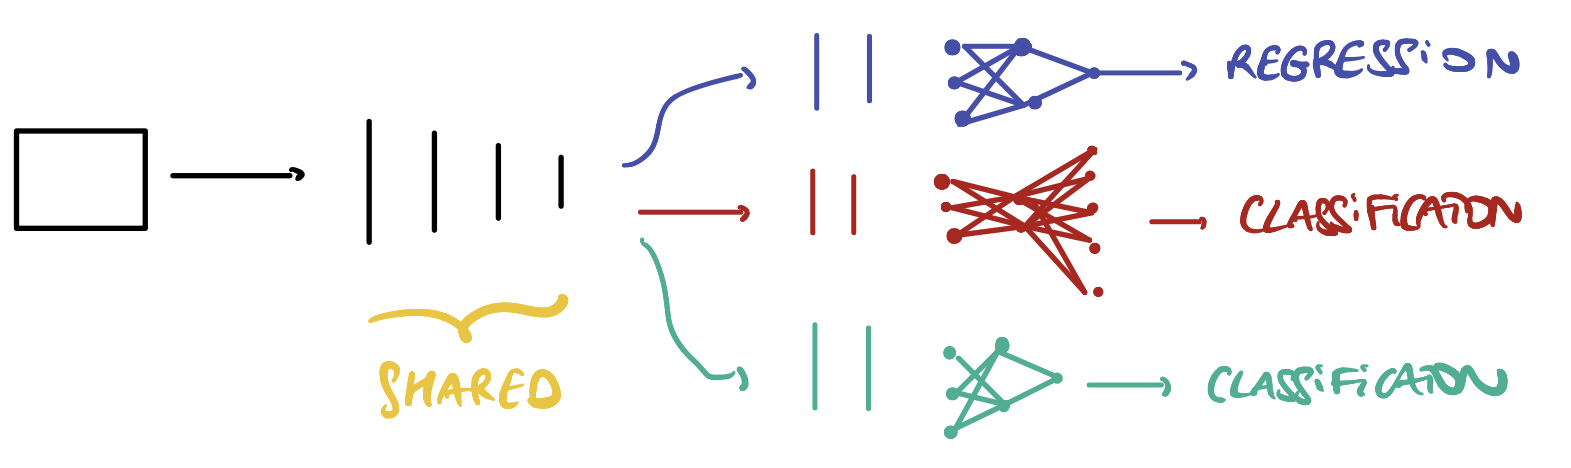

The good thing about Multi-Task Learning is that it's pretty **new**, and we **share weights**. Similarly to when transfer learning helps save time when we train our model, we're going to **save time on training, but also on inference!**. You no longer need to run 3x50 layers to have 3 tasks solved, **you can run one neural network**, and **change the heads**. With that, your network benefit from what the other tasks are learning; **it's like teaching to a class of 3 students who would share what they learn together**, instead of letting them figuring out on their own.<p>

Here's how this workshop is going to happen: 
1.  We're going to **load a multi-task learning dataset** named [UTK Face](https://susanqq.github.io/UTKFace/). It contains 24k images of faces, along with 3 labels: age, gender, and race/ethnicity.
2.  We are going to explore the dataset, and we'll realize that we need to solve **3 tasks**: binary classification (gender), multi-class classification (race), and regression (age).
3.  With PyTorch, we're going to learn how to **create a DataLoader that returns multiple labels**.
4.  To solve the tasks, we'll work with a **pretrained ResNet model**, **behead it**, and **create 3 new heads**.
5.  Finally, we'll **train the model** on a training dataset, and **test on the validation dataset**.
<p>

If you're familiar with PyTorch, this workshop might look simple, but it will be challenging to **get a great accuracy with it**. If you're new to PyTorch, you're gonna love it: We're going to **create everything from scratch**.


# 1 — The UTK Face Dataset
You can download the UTK Face Dataset [here](https://susanqq.github.io/UTKFace/), but I uploaded on Think Autonomous' servers. <p>
**The following wget command will download our dataset.**

![](https://images.squarespace-cdn.com/content/v1/5d6567d1afafe900010b2c70/1567268409336-V7HQTOKOVGT6OYHAER5D/utk-1.jpg)

In [ ]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip

In [ ]:
!jar xf UTKFace.zip

In [ ]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os

# 2 — Very fast Data Exploration
Based on the dataset, you can see that the entire thing is on the name of the images.<p>
For example, the image **UTKFace/100_0_0_20170112213500903.jpg.chip.jpg** can be interpreted as follows:

* UTKFace/ is a prefix
* **100 is the age**
* **0 is the gender** (0: male, 1: female)
* **0 is the race** (0:White, 1:Black, 2:Asian, 3:Indian, 4:Other)
* The rest is the date and the extension (jpg)

So: **[age] _ [gender] _ [race] _ [date&time].jpg**


The example above is the filename for image number 0. Let's pray the image we see is a very old white man.🙏🏻


In [ ]:
image_paths = sorted(glob.glob("UTKFace/*.jpg.chip.jpg"))

images = []
ages = []
genders = []
races = []

for path in image_paths:
    filename = path[8:].split("_")
    if len(filename)==4:
        images.append(np.array(Image.open(path)))
        ages.append(int(filename[0]))
        genders.append(int(filename[1]))
        races.append(int(filename[2]))

In [ ]:
print(len(images))

In [ ]:
dataset_dict = #TODO: Create a dictionary

In [ ]:
idx = np.random.randint(len(images))# Hint: Try 19006 for someone who's gonna yell motherfucka at you!

plt.imshow(images[idx])
plt.show()

print("Age: "+str(ages[idx]))
print("Gender: "+str(dataset_dict['gender_id'][genders[idx]]))
print("Race: "+str(dataset_dict['race_id'][races[idx]]))

## Normalization

In [ ]:
min_age_value, max_age_value = min(ages), max(ages)
log_age_values = np.log10(ages)
max_age_log_value = log_age_values.max()
print('MAX AGE VALUE', max_age_value)
print('MIN AGE VALUE', min_age_value)
print('MAX AGE LOG VALUE', max_age_log_value)

In [ ]:
def get_normalized_age_value(original_age_value):
    return (original_age_value - min_age_value)/(max_age_value - min_age_value)

def get_log_age_value(original_age_value):
    return np.log10(original_age_value)/max_age_log_value

def get_original_age_from_log_value(log_age_value):
    return np.exp(log_age_value) * max_age_log_value

def get_original_age_value(normalized_age_value):
    return normalized_age_value * (max_age_value - min_age_value) + min_age_value

## More Data Exploration

Usually, we should seek for balance in the dataset, we should explore it. Let's not loose to much time here as it's not our #1 Priority.<p>
👉 Kaggle has a competition open for this dataset, and they released [a starter for the data visualization](https://www.kaggle.com/svenknoblauch/utkface-data-exploration). Let's use it directly in our work!

In [ ]:
import seaborn as sns
import pandas as pd

d = {'age': ages, 'gender': genders, 'race': races}
df = pd.DataFrame(data=d)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('age distribution for gender', fontsize=20)

df_age_male = df.groupby('gender').get_group(0)
df_age_female = df.groupby('gender').get_group(1)
sns.histplot(data=df_age_male, x="age", kde=True, color="red", ax=ax1, bins=50)
sns.histplot(data=df_age_female, x="age", kde=True, color="orange", ax=ax2, bins=50)
ax1.title.set_text("male")
ax2.title.set_text("female")


sns.kdeplot(data=df_age_male, x="age", color="red", ax=ax3)
sns.kdeplot(data=df_age_female, x="age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.title.set_text("male vs female")

plt.show()

In [ ]:
pie, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,6])
df.gender.value_counts().plot(kind='pie', labels=["male", "female"], pctdistance=0.5, ax = ax1)
ax1.yaxis.set_visible(False)
ax1.title.set_text('gender distribution')

df.race.value_counts().plot(kind='pie', labels=["White", "Black", "Asian", "Indian", "Others"], pctdistance=0.5, ax = ax2)
ax2.yaxis.set_visible(False)
ax2.title.set_text('race distribution')

plt.show()

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('age distribution for all races', fontsize=20, y=1.1)
fig.tight_layout()

df_race_white = df.groupby('race').get_group(0)
sns.histplot(data=df_race_white, x="age", kde=True, color="red", ax=ax1, bins=40)
ax1.title.set_text("white mean_age: "+"%.2f" % df_race_white.mean()["age"])

df_race_black = df.groupby('race').get_group(1)
sns.histplot(data=df_race_black, x="age", kde=True, color="orange", ax=ax2, bins=40)
ax2.title.set_text("black mean_age: "+"%.2f" % df_race_black.mean()["age"])

df_race_asian = df.groupby('race').get_group(2)
sns.histplot(data=df_race_asian, x="age", kde=True, color="blue", ax=ax3, bins=40)
ax3.title.set_text("asian")
ax3.title.set_text("asian mean_age: "+"%.2f" % df_race_asian.mean()["age"])

df_race_indian = df.groupby('race').get_group(3)
sns.histplot(data=df_race_indian, x="age", kde=True, color="green", ax=ax4, bins=40)
ax4.title.set_text("indian mean_age: "+"%.2f" % df_race_indian.mean()["age"])

df_race_other = df.groupby('race').get_group(4)
sns.histplot(data=df_race_other, x="age", kde=True, color="purple", ax=ax5, bins=40)
ax5.title.set_text("other mean_age: "+"%.2f" % df_race_other.mean()["age"])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

# 3 — Create a Multi-Task DataLoader with PyTorch

In PyTorch, we usually need to create 2 elements:
* A Dataset — That will do exactly what we've done right above
* A Dataloader — That will convert our data in PyTorch format

## Dataset Minimal Code
A dataset needs to implement a class that inherits Dataset with at the minimum 3 things:
```python
def __init__(self):
def __len__(self):
def __getitem__(self):
```
Okay, there are two underscores. It doesn't mean anything bad, just that we're overwritting some functions in Python. 
* The __init__ function is what's called when we create a Dataset. 
* The __len__ function is what's returned when we check the length of our dataset (with len(dataset)). 
* The __getitem__ function is what's called when we call for one element of the dataset (with dataset[i])

In [ ]:
# Just in case your images don't load properly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
class UTKFace(Dataset):
    def __init__(self, image_paths):
        # Mean and Std for ImageNet
        mean=[0.485, 0.456, 0.406] # ImageNet
        std=[0.229, 0.224, 0.225] # ImageNet

        # Define the Transforms
        self.transform = #TODO: Create 3 transforms: Resize, To Tensor, Normalize

        # Set Inputs and Labels
        self.image_paths = image_paths
        self.images = []
        self.ages = []
        self.genders = []
        self.races = []

        for path in image_paths:
            filename = path[8:].split("_")
            if len(filename)==4:
                self.images.append(path)
                self.ages.append(int(filename[0]))
                self.genders.append(int(filename[1]))
                self.races.append(int(filename[2]))
    
    def __len__(self):
         return len(self.images)

    def __getitem__(self, index):
        # Load an Image
        img = #TODO: Load an Image
        # Transform it
        img = #TODO: Transform it

        # Get the Labels
        age = #TODO: 
        gender = #TODO: 
        race = #TODO: 
        
        # Return the sample of the dataset
        sample = #TODO: 
        return sample

## Train/Test Split

In [ ]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [ ]:
# define the train and val splits
TRAIN_SPLIT = #TODO: 
VAL_SPLIT = #TODO: 

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_train = round(TRAIN_SPLIT*len(image_paths))
num_val = round(VAL_SPLIT*len(image_paths))

print('No of train samples', num_train)
print('No of validation Samples', num_val)

In [ ]:
(train_dataset, valid_dataset) = random_split(image_paths,[num_train, num_val],generator=torch.Generator().manual_seed(42))

## Dataloader

In [ ]:
BATCH_SIZE = #TODO: 

train_dataloader = #TODO: 
val_dataloader = #TODO: 

train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps = len(val_dataloader.dataset) // BATCH_SIZE

In [ ]:
def imshow(img):
    #TODO: 

In [ ]:
sample = next(iter(train_dataloader))

imshow(sample['image'][0])
plt.show()
print(sample["age"][0].item())
print(get_normalized_age_value(sample["age"][0].item()))


print(dataset_dict['gender_id'][sample["gender"][0].item()])
print(dataset_dict['race_id'][sample["race"][0].item()])

# 4 — Multi-Task Neural Network with PyTorch

In this part, we want to:
1. Define a Base Neural Network
2. Create the Heads
3. Train it
4. Test it


### Define the Base Model
In this part, we're going to load a pretrained Resnet18. **In this part, I'm going to teach you how to add layers to a pretrained network, no matter the nework, so if you'd like to load an Inception v3 and go all Dicaprio on this, be my guest!**


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, resnet101, resnet18, resnet34

In [ ]:
net = #TODO:

In [ ]:
!pip install torchviz
from torchviz import make_dot

#make_dot(net(sample["image"].to(device)), params=dict(list(net.named_parameters()))).render("ResNet50", format="png")

## Create the HydraNet class


The final layer is called net.fc. If we want to add layers to that, we can always change that layer, or add layers after this one.


Here's an example when changing this final layer to a 10 neuron output:
```python
self.net = models.resnet18(pretrained=True)
self.net.fc = nn.Linear(model.fc.in_features, 10)
```

We can also use the OrderedDict method and have a set of layers (a real head!):
```python
from collections import OrderedDict
self.n_features = self.net.fc.in_features
self.net.fc1 = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(self.n_features,self.n_features)),
    ('relu1', nn.ReLU()),
    ('final', nn.Linear(self.n_features, 1))
    ]))
```

In [ ]:
from collections import OrderedDict

In [ ]:
class HydraNetModified(nn.Module):
    def __init__(self, net):
        pass
        #TODO: 
        
    def forward(self, x):
        pass
        #TODO: 

In [ ]:
model = #TODO: 
model.to(device=device)

race_loss = #TODO:
gender_loss = #TODO:
age_loss = #TODO: 

lr =#TODO: 
momentum = 0.09 # Meaning that we will go 9% with the previous direction
optimizer = #TODO: 

In [ ]:
#make_dot(model(sample["image"].to(device)), params=dict(list(model.named_parameters()))).render("HydraNet", format="png")

## Train the Model
Here's a typical training loop in PyTorch
```python
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataLoader:
        images, labels = data
        outputs = model(images)
        loss = criterion_label(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) 

    epoch_loss = running_loss / len(dataloaders['train'])
    losses.append(epoch_loss)
    plt.plot(losses)
```

In our case, it will be a bit different, as we have several types of losses to plot (3x2)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

n_epochs = #TODO: 

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_gender_loss": list(),
          "train_race_loss": list(),
          "train_age_loss": list(),
          "validation_gender_loss": list(),
          "validation_race_loss": list(),
          "validation_age_loss": list(),
          }

In [ ]:
sig = nn.Sigmoid()

for epoch in range(n_epochs):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_race_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_race_loss = 0
    validation_age_loss = 0

    for i, data in enumerate(train_dataloader):
        inputs = #
        age_label = #
        gender_label = #
        race_label = #

        #TODO: Zero Grad
        age_output, gender_output, race_output = #
        
        loss_1 = #
        loss_2 = #
        loss_3 = #

        loss = #

        #Backward
        #Step
        total_training_loss += loss
        
        training_race_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_age_loss += loss_3.item()
    print('EPOCH ', epoch+1)
    print("Training Losses: Race: {}, Gender: {}, Age: {}".format(loss_1, loss_2, loss_3))

    with torch.no_grad():
        model.eval()

        for i, data in enumerate(val_dataloader):
            inputs = #
            age_label = #
            gender_label = #
            race_label =  #
            age_output, gender_output, race_output = #
        
            loss_1 = #
            loss_2 = #
            loss_3 = #

            loss = #
            total_validation_loss += loss

            validation_race_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_age_loss += loss_3.item()
        print("Validation Losses: Race: {}, Gender: {}, Age: {}".format(loss_1, loss_2, loss_3))

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print() 
    avgTrainGenderLoss = training_gender_loss/len(train_dataloader.dataset)
    avgTrainRaceLoss = training_race_loss/len(train_dataloader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_dataloader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_dataloader.dataset)
    avgValRaceLoss = validation_race_loss/len(val_dataloader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_dataloader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_race_loss"].append(avgTrainRaceLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_race_loss"].append(avgValRaceLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)


In [ ]:
torch.save(model.state_dict(), "best_model.pth")

##Show the Results

In [ ]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_gender_loss"])
plt.plot(logger["validation_gender_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_race_loss"])
plt.plot(logger["validation_race_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_age_loss"])
plt.plot(logger["validation_age_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Inference

In [ ]:
indexes = valid_dataset.indices
test_indices = indexes[0:10]

In [ ]:
for idx in test_indices:
    plt.figure()
    plt.imshow(images[idx])
    plt.show()

    image_norm = #
    image_norm = #

    model.eval()
    age, gender, race = #

    predicted_age = #

    print("Age:", str(ages[idx]), "| Predicted:", str(int(predicted_age)))

    sigmoid = nn.Sigmoid()
    out_gender = #
    gender_classes = ["male", "female"]
    print("Gender:", str(dataset_dict['gender_id'][genders[idx]]), "| Predicted:", str(gender_classes[out_gender]))

    out_race = #
    race_classes = ["white", "black", "asian", "indian", "other"]
    print("Race:", str(dataset_dict['race_id'][races[idx]]), "| Predicted:", str(race_classes[out_race]))
    print('\n')